# Final Project: Clean Label Poison Attack On Traffic Sign Dataset (Unfrozen Model)

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing PyTorch and Packages


In [2]:
import os
from os import listdir
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
from torchvision.models import resnet34, ResNet34_Weights
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, ToPILImage
from torchvision.transforms import v2
from google.colab.patches import cv2_imshow

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from collections import Counter

from prettytable import PrettyTable
import operator
import os.path

# this debugs plt.imshow
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# set seeds

np.random.seed(11)
random.seed(11)
torch.manual_seed(11)
torch.cuda.manual_seed(11)

# Loading Data

In [4]:
# Load traffic sign dataset from Google Drive
# Source: https://www.kaggle.com/andrewmvd/road-sign-detection

# Parse XML files
img_path = Path('/content/drive/MyDrive/roadsigns/images')
anno_base_path = Path('/content/drive/MyDrive/roadsigns/annotations')
class_dict = {'trafficlight': 0, 'crosswalk': 1, 'speedlimit': 2, 'stop': 3}

def get_files(root, file_type):
  return [os.path.join(directory_path, f) for directory_path, directory_name,
            files in os.walk(root) for f in files if f.endswith(file_type)]

# Create Pandas Dataframe With Filename, Height, Width, Class, and Bounding Boxes
def make_train_df(anno_base_path):
  annotations = get_files(anno_base_path, '.xml')
  anno_list = []
  for anno_path in annotations:
    root = ET.parse(anno_path).getroot()
    for obj in root.findall('object'):
      anno = {}
      anno['filename'] = Path(str(img_path) + '/' + root.find("./filename").text)
      anno['width'] = root.find("./size/width").text
      anno['height'] = root.find("./size/height").text
      classname = obj.find("./name").text
      anno['class'] = class_dict[str(classname)]
      anno['xmin'] = int(obj.find("./bndbox/xmin").text)
      anno['ymin'] = int(obj.find("./bndbox/ymin").text)
      anno['xmax'] = int(obj.find("./bndbox/xmax").text)
      anno['ymax'] = int(obj.find("./bndbox/ymax").text)
      anno_list.append(anno)
  return pd.DataFrame(anno_list)

# Create training dataframe
df_train = make_train_df(anno_base_path)

# Analyze Dataset - dataset is heavily skewed towards speedlimit signs
print(df_train.shape)
print(df_train.head())
print(df_train.describe())
print(df_train['class'].value_counts())

(1244, 8)
                                            filename width height  class  \
0  /content/drive/MyDrive/roadsigns/images/road10...   400    200      2   
1  /content/drive/MyDrive/roadsigns/images/road11...   400    247      2   
2  /content/drive/MyDrive/roadsigns/images/road12...   400    283      2   
3  /content/drive/MyDrive/roadsigns/images/road10...   400    364      2   
4  /content/drive/MyDrive/roadsigns/images/road11...   400    274      2   

   xmin  ymin  xmax  ymax  
0   195     7   392   194  
1   254    32   319   102  
2    79    20   230   229  
3    48    14   344   345  
4   171    38   307   186  
             class         xmin         ymin         xmax         ymax
count  1244.000000  1244.000000  1244.000000  1244.000000  1244.000000
mean      1.639068   120.271704   165.429260   173.812701   225.758039
std       0.806720    54.799893    74.359084    63.751096    66.051956
min       0.000000     0.000000     0.000000     7.000000    31.000000
25%       

In [5]:
# get list of class images

#sign_class = 1
#sign_class = df_train[df_train['class'] == sign_class]
#sign_class = sign_class['filename'].apply(os.path.basename)
#pd.set_option("display.max_rows", None, "display.max_columns", None)
#print(sign_class)

In [6]:
pd.set_option('display.max_colwidth', None)
#print(x_test['new_path'])
#print(x['new_path'])
#print(df_train)#

# Resize Images and Process Bounding Boxes

In [7]:
# Transformation Functions

def read_image(path):
    # read image
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, img):
    # Create mask for the bounding box of same shape as image
    rows,cols,*_ = img.shape
    mask = np.zeros((rows, cols))
    bb = bb.astype(int)
    mask[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return mask

def mask_to_bb(mask):
    # Convert mask to a bounding box, assumes 0 as background nonzero object
    cols, rows = np.nonzero(mask)
    if len(cols)==0:
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(img):
    # Generates bounding box array from a df_train row
    return np.array([img[5],img[4],img[7],img[6]])

def resize_img_bb(r_path, w_path, bb, size):
    # Resize image and bounding box and write image to new path
    img = read_image(r_path)
    img_resized = cv2.resize(img, (int(1.49*size), size))
    im_resized = cv2.resize(create_mask(bb, img), (int(1.49*size), size))
    new_path = f'{w_path}/{r_path.parts[-1]}'
    cv2.imwrite(new_path, cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))
    print(f'saved resized img to {new_path}')
    return new_path, mask_to_bb(im_resized)

def resize_img_bb_and_save(r_path, w_path, bb, size):
    # Resize image and bounding box and write image to new path
    img = read_image(r_path)
    img_resized = cv2.resize(img, (int(1.49*size), size))
    im_resized = cv2.resize(create_mask(bb, img), (int(1.49*size), size))
    new_path = f'{w_path}/{r_path.parts[-1]}'
    cv2.imwrite(new_path, cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))
    print(f'saved resized img to {new_path}')
    new_bb_path = f'{w_path}/{r_path.parts[-1]}.bb.npy'
    bb_resized = mask_to_bb(im_resized)
    np.save(new_bb_path, bb_resized)
    print(f'saved resized bounding box to {new_bb_path}')
    return new_path, bb_resized

def load_or_resize_img_bb(r_path, w_path, bb, size):
    new_path = f'{w_path}/{r_path.parts[-1]}'
    new_bb_path = f'{w_path}/{r_path.parts[-1]}.bb.npy'
    if os.path.isfile(new_path) and os.path.isfile(new_bb_path):
      bb_resized = np.load(new_bb_path)
      return new_path, bb_resized
    return resize_img_bb_and_save(r_path, w_path, bb, size)

#Check Images and Bounding Boxes

In [8]:
# Sample image
idx = 58
img = cv2.imread(str(df_train.values[idx][0]))
bb = create_bb_array(df_train.values[idx])
print(img.shape)

# Check mask function
mask = create_mask(bb, img)
mask_to_bb(mask)

(225, 400, 3)


array([ 74., 147., 162., 243.], dtype=float32)

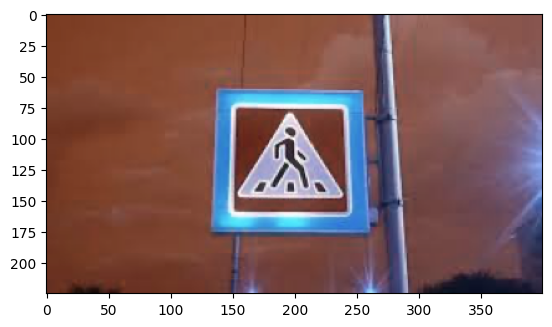

In [9]:
# Images load as BGR
plt.imshow(img)

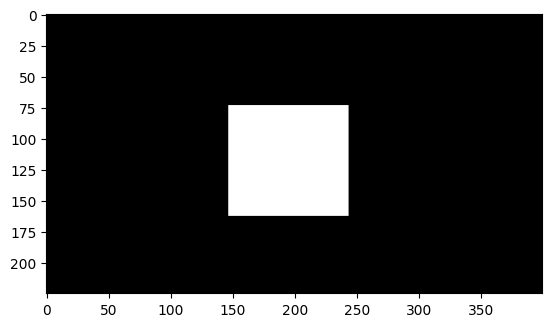

In [10]:
# Show mask
plt.imshow(mask, cmap='gray')

#Resize Images and Bounding Boxes

In [11]:
# Functions to show bounding box

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=1)

def show_corner_bb(img, bb):
    plt.imshow(img)
    plt.gca().add_patch(create_corner_rect(bb))

def show_image(img, bb):
    plt.imshow(img)

# Function to show tensor converted to image

def imshow_tensor(tensor):
  # Imshow function with tensor as input
    img = tensor_to_img(tensor)
    plt.imshow(img)

In [12]:
# Create new data folder with resized images and add new bounding box values to dataframe
# Images resized to 300 x 447
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/roadsigns/images_resized')
for index, row in df_train.iterrows():
    #new_path, new_bb = resize_img_bb(row['filename'], train_path_resized, create_bb_array(row.values), 300)
    new_path, new_bb = load_or_resize_img_bb(row['filename'], train_path_resized, create_bb_array(row.values), 300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

(1244, 10)
                                              filename width height  class  \
0  /content/drive/MyDrive/roadsigns/images/road101.png   400    200      2   
1  /content/drive/MyDrive/roadsigns/images/road114.png   400    247      2   
2  /content/drive/MyDrive/roadsigns/images/road120.png   400    283      2   
3  /content/drive/MyDrive/roadsigns/images/road104.png   400    364      2   
4  /content/drive/MyDrive/roadsigns/images/road113.png   400    274      2   

   xmin  ymin  xmax  ymax  \
0   195     7   392   194   
1   254    32   319   102   
2    79    20   230   229   
3    48    14   344   345   
4   171    38   307   186   

                                                      new_path  \
0  /content/drive/MyDrive/roadsigns/images_resized/road101.png   
1  /content/drive/MyDrive/roadsigns/images_resized/road114.png   
2  /content/drive/MyDrive/roadsigns/images_resized/road120.png   
3  /content/drive/MyDrive/roadsigns/images_resized/road104.png   
4  /content/dri

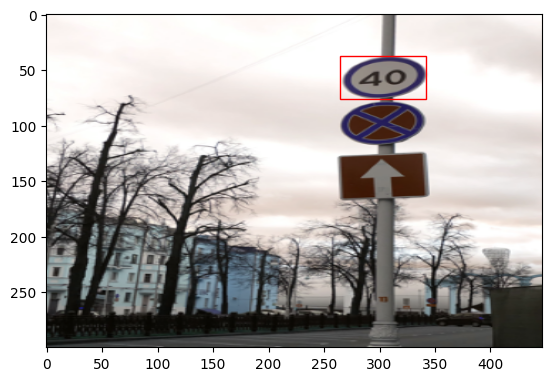

In [13]:
# Check resizing results
print(df_train.shape)
print(df_train.head())

# Sample resized image and check mask location (looks decent)
idx = 100
img = cv2.imread(str(df_train.values[idx][8]))
print(img.shape)
bb = df_train.values[idx][9]
print(bb)
show_corner_bb(img, bb)

#Dataset Augmentations

###Flip, Rotation, Center Crop, Random Crop, and Transform Functions

In [14]:
# Crop function for input x
def crop(x, r, c, target_r, target_c):
    return x[r:r+target_r, c:c+target_c]

# Random crop to the original size
def random_crop(img, r_pix=8):
    r, c,*_ = img.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(img, start_r, start_c, r-2*r_pix, c-2*c_pix)

# Center crop function for input x
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

# Flip Rotate by deg=deg for input x
def rotate_img(x, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    r,c,*_ = x.shape
    M = cv2.getRotationMatrix2D((c/2,r/2), deg, 1)
    if y:
        return cv2.warpAffine(x, M, (c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(x, M, (c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

# Random crop for image and mask
def rand_crop_img_mask(img, mask, r_pix=8):
    r, c,*_ = img.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    img_crop = crop(img, start_r, start_c, r-2*r_pix, c-2*c_pix)
    mask_crop = crop(mask, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return img_crop, mask_crop

# Transform function for images and mask
def transforms_img_mask(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    img = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    mask = create_mask(bb, img)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        img = rotate_img(img, rdeg)
        mask = rotate_img(mask, rdeg, y=True)
        # Flipping makes number and text recognition unnecessarily difficult
        #if np.random.random() > 0.5:
        #    img = np.fliplr(img).copy()
        #    mask = np.fliplr(mask).copy()
        img, mask = rand_crop_img_mask(img, mask)
    else:
        img, mask = center_crop(img), center_crop(mask)
    return img, mask_to_bb(mask)

In [15]:
class RoadSigns(Dataset):
    def __init__(self, path, bb, labels, transforms=False):
        self.path = path.values
        self.bb = bb.values
        self.labels = labels.values
        self.transforms = transforms
        self.replacements = {}

    def __len__(self):
        return len(self.path)

    def __repr__(self):
        return "<path:%s labels:%s>" % (self.path, self.labels)

    def __getitem__(self, idx):
        path = self.path[idx]
        label = self.labels[idx]
        key = f'{path}-{label}'

        # if poisoned replacement, return that replacement
        if key in self.replacements:
          vals = self.replacements[key]
          #print(f'getitem got replacement img with shape {vals[0].shape}')
          return vals[0], self.labels[idx], vals[1], path

        #perform random image transforms when transforms = True
        n_img, n_bb = transforms_img_mask(path, self.bb[idx], self.transforms)
        n_img = normalize(n_img)
        n_img = np.moveaxis(n_img, 2, 0)

        self.replacements[key] = (n_img, n_bb)

        return n_img, self.labels[idx], n_bb, path

    def get_by_name(self, file_name, label):
      for i in range(len(self)):
        if file_name in self.path[i]:
          path = self.path[i]
          key = f'{path}-{label}'

          if key in self.replacements:
            vals = self.replacements[key]
            #print(f'get_by_name got replacement img with shape {vals[0].shape}')
            return vals[0], self.labels[i], vals[1], path

          print(f'somehow no pre-generated image for {key}')
          n_img, n_bb = transforms_img_mask(path, self.bb[i], self.transforms)
          n_img = normalize(n_img)
          n_img = np.moveaxis(n_img, 2, 0)

          self.replacements[key] = (n_img, n_bb)

          return n_img, self.labels[i], n_bb, path

      return None

    def replace_by_name(self, file_name, label, img):
      for i in range(len(self)):
        if file_name in self.path[i]:
          path = self.path[i]
          example_label = self.labels[i]
          if label == example_label:
            key = f'{path}-{label}'
            self.replacements[key] = (img, self.bb[i])
            break

    def remove_by_name(self, file_name, label):
      for i in range(len(self)):
        if file_name in self.path[i]:
          path = self.path[i]
          key = f'{path}-{label}'
          if key in self.replacements:
            del self.replacements[key]
            break

#Poisoning Functions



In [16]:
# Poison bounding box portion of full image with epsilon pixel shift - too weak

def poison_img_shift_bb(img, bb, epsilon):
  # get bounding box coordinates
  bbuly, bbulx, bblry, bblrx = bb
  # convert to integers
  bbuly, bbulx, bblry, bblrx = int(bbuly), int(bbulx), int(bblry), int(bblrx)
  # extract the region inside the bounding box
  roi = img[bbuly:bblry, bbulx:bblrx]
  # shift pixel colors by epsilon pixels
  shifted_image = roi + epsilon
  # Bound pixel values to valid pixel range [0, 255]
  shifted_img = np.clip(img + epsilon, 0, 255).astype(np.uint8)
  return shifted_img

In [17]:
# Poison bounding box portion of image with gaussian noise - too weak

def poison_img_noise_bb(img, bb, mean, sigma):
  # get bounding box coordinates
  bbuly, bbulx, bblry, bblrx = bb
  # convert to integers
  bbuly, bbulx, bblry, bblrx = int(bbuly), int(bbulx), int(bblry), int(bblrx)
  # extract the region inside the bounding box
  roi = img[bbuly:bblry, bbulx:bblrx]
  # add random gaussian noise
  noise = np.random.normal(mean, sigma, roi.shape).astype(np.uint8)
  noisy_image = cv2.add(roi, noise)
  img[bbuly:bblry, bbulx:bblrx] = noisy_image
  return img

In [18]:
# Function to perform feature space perturbation from poison frogs white paper - huge surprise, this works

# Convert image to tensor
def make_tensor(dataset, model, example, label):
  img, label, bb, path = dataset.get_by_name(example, label)
  #img = np.moveaxis(img, 2, 0)
  float_img = torch.FloatTensor(img[None,])
  return float_img

def poison_base_target(model, x, base_instance, target_instance, beta_0 = 0.25, lr=0.01):
  #base_instance, b
  #target_instance, t
  #beta value and lr borrowed from poison frogs white paper

  x.requires_grad = True
  fs_t = model.feature_space(target_instance.view(1,*target_instance.shape)).detach()
  fs_t.requires_grad = False

  # Forward Step:
  dif = model.feature_space(x.view(1,*x.shape))-fs_t
  loss = torch.sum(torch.mul(dif,dif))
  loss.backward()
  x2 = x.clone()
  x2-=(x.grad*lr)

  # Backward Step:
  x = (x2+lr*beta_0*base_instance)/(1+lr*beta_0)
  return x, loss.item()

# Function to run poison function for 1000 iterations and check the loss

def poison_iters(model, train_ds, test_ds, base, blabel, target, tlabel):
  #make tensors
  #base_tensor = make_tensor(train_ds, model_name, base, blabel)
  #target_tensor = make_tensor(train_ds, model_name, target, tlabel)
  base_tensor, label, bb, path = train_ds.get_by_name(base, blabel)
  base_tensor_f = torch.FloatTensor(base_tensor[None,])
  target_tensor, label, bb, path = test_ds.get_by_name(target, tlabel)
  target_tensor_f = torch.FloatTensor(target_tensor[None,])
  #squeeze tensors
  base_instance = base_tensor_f.squeeze().cuda()
  target_instance = target_tensor_f.squeeze().cuda()
  # run poison frogs algorithm and check loss
  x = base_instance
  for i in range(1000):
    x, loss = poison_base_target(model, x.detach(), base_instance, target_instance)
    if i % 50 == 0:
        print(loss)
  return x

#Normalize Functions


In [19]:
# Images normalized to ResNet34 model using Imagenet stats (https://pytorch.org/hub/pytorch_vision_resnet/)

def normalize(img):
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  return (img - mean)/std

def tensor_to_img(tensor):
  # tensor renormalized
  img = np.transpose(tensor.numpy(), (1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  #img = np.transpose(img, (2, 0, 1))
  img = np.clip(img, 0, 1)
  return img

# Demo Bounding Box and Transformations

/content/drive/MyDrive/roadsigns/images_resized/road67.png
[ 71. 125. 240. 289.]
/content/drive/MyDrive/roadsigns/images/road67.png


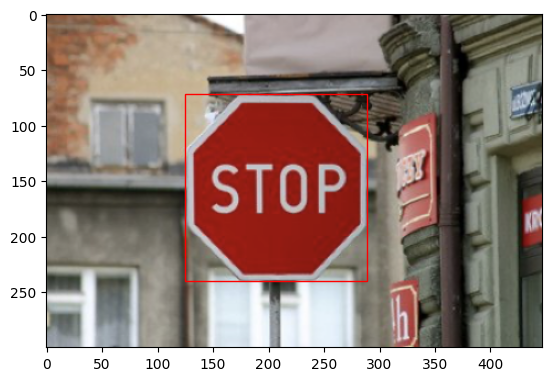

In [20]:
# Show bounding box on resized stop sign
# Images will not be rewritten to files
idx = 837

im = cv2.imread(str(df_train.values[idx][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(str(df_train.values[idx][8]))
print(df_train.values[idx][9])
show_corner_bb(im, df_train.values[idx][9])
print(df_train.values[idx][0])

## Process Dataset for Training

In [21]:
# Split dataset into train and test sets

#df_train = df_train.reset_index()

x = df_train[['new_path', 'new_bb']]
y = df_train['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)

In [22]:
# Calculate class weights for Random Sampler

class_weights = 1 / y_train.value_counts()
print(class_weights)
class_counts = y_train.value_counts()
sample_weights = [1/class_counts[i] for i in y_train.values]
print(sample_weights[:5])

2    0.001582
1    0.006173
0    0.007576
3    0.014493
Name: class, dtype: float64
[0.0015822784810126582, 0.007575757575757576, 0.0015822784810126582, 0.0015822784810126582, 0.0015822784810126582]


Dataset Class for Transformation and Poisoning

#Create Datasets and Dataloaders

In [23]:
# Create datasets and dataloaders for training and testing

batch_size = 64

train_ds = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, transforms=True)
test_ds = RoadSigns(x_test['new_path'], x_test['new_bb'], y_test)

#Weighted Random Sampler removed - does not increase accuracy and impedes poisoning
#sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_ds), replacement=True)
#train_dl = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [24]:
# Print full dataset items to check contents
def list_dataset_images(test_ds):
  all_images = []
  for i in range(0, len(test_ds)):
    img, label, bb, path = test_ds[i]
    all_images.append({'path': test_ds[i][-1],
                       'label': test_ds[i][1]})
  table = PrettyTable()
  table.title = "All Images"
  table.field_names = ["Path", "Label"]
  for entry in all_images:
    table.add_row([entry['path'], entry['label']])
  print(table.get_string(sortby="Label"))

## Model Definition

In [25]:
# Model definition for pretrained ResNet34

class RoadSignModel(nn.Module):
  def __init__(self, freeze_layers = False):
      super(RoadSignModel, self).__init__()
      #load pretrained ResNet34 model and
      torch.manual_seed(11)
      resnet = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
      layers = list(resnet.children())[:8]

      if freeze_layers:
        # freeze Resnet34 layers
        for layer in layers:
          for param in layer.parameters():
            param.requires_grad = False

      self.features1 = nn.Sequential(*layers[:6])
      self.features2 = nn.Sequential(*layers[6:])
      #classifier layer for 4 label classification
      self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
      #regression layer for bounding boxes
      self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))

  def forward(self, x):
      x = self.features1(x)
      x = self.features2(x)
      x = F.relu(x)
      x = nn.AdaptiveAvgPool2d((1,1))(x)
      x = x.view(x.shape[0], -1)
      return self.classifier(x), self.bb(x)

  def feature_space(self, x):
      x = self.features1(x)
      x = self.features2(x)
      x = F.relu(x)
      x = nn.AdaptiveAvgPool2d((1,1))(x)
      x = x.view(x.shape[0], -1)
      return x

## Functions for Training and Test

In [26]:
# Model requires cross entropy loss for images and L1 regression for bounding boxes
# L1 loss scaled down by a factor of 1000 to combine losses for both features

def train(model, optimizer, train_dl, test_dl, epochs):
    torch.cuda.empty_cache()
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb, path in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/1000
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        test_loss, test_acc = metrics(model, test_dl)
        print("train_loss %.3f test_loss %.3f test_accuracy %.3f" % (train_loss, test_loss, test_acc))
    return sum_loss/total

# Evaluation: compute accuracy on test set
def metrics(model, test_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y_class, y_bb, path in test_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/1000
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

# Save model
def save_model(model, name):
  path = Path('/content/drive/MyDrive/roadsigns/models')
  file = os.path.join(path, name)
  torch.save(model, file)

# Load model
def load_model(name):
  path = Path('/content/drive/MyDrive/roadsigns/models')
  file = os.path.join(path, name)
  return torch.load(file)

#Inference Functions

In [27]:
# Model classification inference function
# confusion matrix, classification report, misclassified example table

def inference(test_ds, model):
  y_true = []
  y_pred = []
  misclassified = []

  for i in range(0, len(test_ds)):
    img, label, bb, path = test_ds[i]
    float_img = torch.FloatTensor(img[None,])
    out_label, out_bb = model(float_img.cuda())
    label_probs = torch.softmax(out_label, 1)
    list = label_probs[0].tolist()
    y_true.append(label)
    pred_label = list.index(max(list))
    y_pred.append(pred_label)
    if y_true[i] != y_pred[i]:
      misclassified.append({'path': test_ds[i][-1],
                            'true_label': y_true[i],
                            'pred_label': y_pred[i]})
  # confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()
  target_names = ['trafficlight:0', 'crosswalk:1', 'speedlimit:2', 'stop:3']
  #classification report
  print(classification_report(y_true, y_pred, target_names = target_names))

  # print misclassified example table
  table = PrettyTable()
  table.title = "Misclassified Images"
  table.field_names = ["Path", "True Label", "Predicted Label"]
  for entry in misclassified:
    table.add_row([entry['path'], entry['true_label'], entry['pred_label']])
  print(table.get_string(sortby="True Label"))

# Get misclassified examples
def misclassified(misclassified_examples, adversarial_class, target_class):
  examples = [ex for ex in misclassified_examples if ex['true_label'] == target_class and ex['pred_label'] == adversarial_class]
  example_paths = [obj['path'] for obj in examples]
  return example_paths

# Predict exanple performance on model
def example_inference(dataset, model, example, label):
  loaded_model = load_model(model)
  img_t, label_p, bb_p, path_p = dataset.get_by_name(example, label)
  img = np.moveaxis(img_t, 0, 2)
  show_corner_bb(img, bb_p)
  print(label_p)
  float_img_t = torch.FloatTensor(img_t[None,])
  out_label, out_bb = loaded_model(float_img_t.cuda())
  prob = torch.softmax(out_label, 1)
  #im = read_image(path_p)
  #plt.imshow(img_p)
  return prob

# Predict poison performance on model
def poison_inference(poisoned_base, model_name):
  poisoned_base = torch.unsqueeze(poisoned_base, 0)
  model = load_model(model_name)
  out_label, out_bb = model(poisoned_base.cuda())
  prob = torch.softmax(out_label, 1)
  print(prob)

# Make grid function for the dataloader
def image_grid(train_dl):
  # Get a batch of training data
  imgs, labels, bbs, paths = next(iter(train_dl))
  # Make a grid from batch
  grid = make_grid(imgs, nrow=8)
  imshow_tensor(grid)

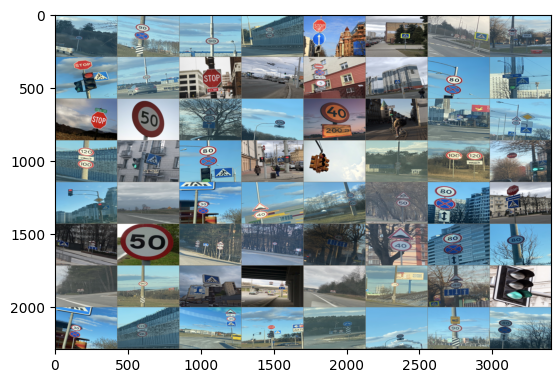

In [28]:
# Visually survey the data
image_grid(train_dl)

# Model Training and Inference

In [29]:
# Model training and evaluation functions

def model_inference(model_name, test_ds):
  # load model and run inference on model
  model = load_model(model_name)
  result = inference(test_ds, model)
  print(result)
  del model

def model_eval(model, optimizer, train_dl, test_dl, test_ds, lr, epochs, model_name):
  # train the model
  train(model, optimizer, train_dl, test_dl, epochs)
  # save model
  save_model(model, model_name)
  # run model inference
  model_inference(model_name, test_ds)

# Unfrozen Baseline Model

In [30]:
# Parameters and inputs
uf_epochs = 10
uf_lr = 1e-5
uf_model_name = "unfrozen.pt"
uf_model = RoadSignModel().cuda()
uf_parameters = filter(lambda p: p.requires_grad, uf_model.parameters())
uf_optimizer = torch.optim.Adam(uf_parameters, lr=uf_lr)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 152MB/s]


train_loss 1.985 test_loss 1.728 test_accuracy 0.598
train_loss 1.618 test_loss 1.557 test_accuracy 0.651
train_loss 1.426 test_loss 1.487 test_accuracy 0.699
train_loss 1.270 test_loss 1.452 test_accuracy 0.707
train_loss 1.155 test_loss 1.408 test_accuracy 0.707
train_loss 1.051 test_loss 1.361 test_accuracy 0.735
train_loss 0.970 test_loss 1.369 test_accuracy 0.739
train_loss 0.901 test_loss 1.328 test_accuracy 0.755
train_loss 0.852 test_loss 1.342 test_accuracy 0.755
train_loss 0.827 test_loss 1.364 test_accuracy 0.747


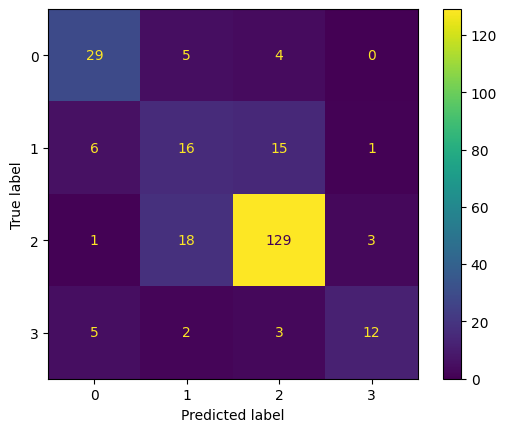

                precision    recall  f1-score   support

trafficlight:0       0.71      0.76      0.73        38
   crosswalk:1       0.39      0.42      0.41        38
  speedlimit:2       0.85      0.85      0.85       151
        stop:3       0.75      0.55      0.63        22

      accuracy                           0.75       249
     macro avg       0.68      0.65      0.66       249
  weighted avg       0.75      0.75      0.75       249

+--------------------------------------------------------------------------------------------+
|                                    Misclassified Images                                    |
+-------------------------------------------------------------+------------+-----------------+
|                             Path                            | True Label | Predicted Label |
+-------------------------------------------------------------+------------+-----------------+
| /content/drive/MyDrive/roadsigns/images_resized/road136.png |     0     

In [31]:
# Train and evaluate the unfrozen baseline model

model_eval(uf_model, uf_optimizer, train_dl, test_dl, test_ds, uf_lr, uf_epochs, uf_model_name)

In [32]:
# check contents of test_ds to ensure targets are included

list_dataset_images(test_ds)

+---------------------------------------------------------------------+
|                              All Images                             |
+-------------------------------------------------------------+-------+
|                             Path                            | Label |
+-------------------------------------------------------------+-------+
|  /content/drive/MyDrive/roadsigns/images_resized/road11.png |   0   |
|  /content/drive/MyDrive/roadsigns/images_resized/road12.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road127.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road129.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road136.png |   0   |
|  /content/drive/MyDrive/roadsigns/images_resized/road16.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road179.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road200.png |   0   |
|  /content/drive/MyDrive/roadsigns/images_resized/road21.png | 

In [33]:
# check contents of train_ds

list_dataset_images(train_ds)

+---------------------------------------------------------------------+
|                              All Images                             |
+-------------------------------------------------------------+-------+
|                             Path                            | Label |
+-------------------------------------------------------------+-------+
|  /content/drive/MyDrive/roadsigns/images_resized/road0.png  |   0   |
|  /content/drive/MyDrive/roadsigns/images_resized/road1.png  |   0   |
|  /content/drive/MyDrive/roadsigns/images_resized/road10.png |   0   |
|  /content/drive/MyDrive/roadsigns/images_resized/road11.png |   0   |
|  /content/drive/MyDrive/roadsigns/images_resized/road12.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road124.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road124.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road124.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road127.png | 

# Pick Poison Pairs

3


tensor([[1.4763e-02, 4.0923e-02, 1.0228e-06, 9.4431e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

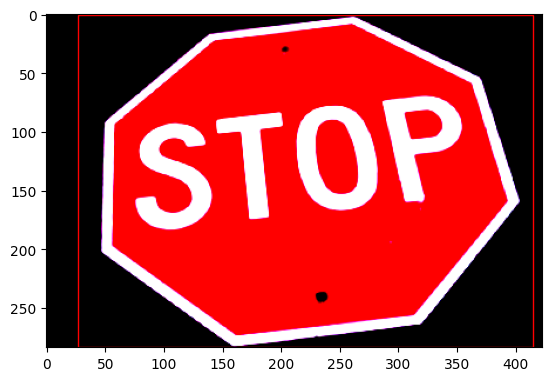

In [34]:
# Find a base image to poison (base is stop sign)

base = 'road64.png'
b_label = 3

# check classification on frozen model
example_inference(train_ds, uf_model_name, base, b_label)

0


tensor([[7.8126e-01, 7.1504e-02, 1.8658e-04, 1.4705e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

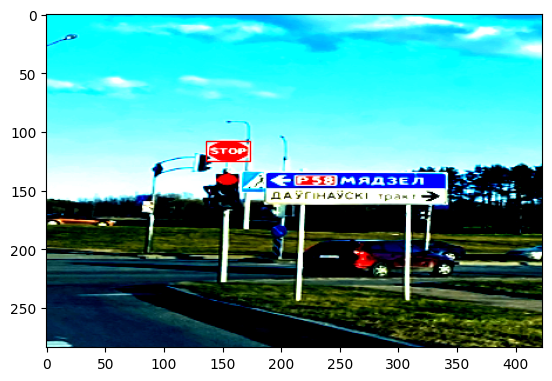

In [35]:
# Find a target image to attack (target is traffic light)

target = 'road819.png'
t_label = 0

# check classification on frozen model - function pulling wrong bb, but no time to debug, tensor tells me which image I selected in a multi-class image
example_inference(test_ds, uf_model_name, target, t_label)

In [36]:
# Poison base instance using target instance using the unfrozen model and show loss during algorithm

model = load_model(uf_model_name)
ufp_base = poison_iters(model, train_ds, test_ds, base, b_label, target, t_label)

463.5792541503906
59.92329406738281
40.80667495727539
33.100067138671875
28.734371185302734
25.743648529052734
23.73431396484375
21.788393020629883
20.427898406982422
19.362892150878906
18.701513290405273
18.284076690673828
17.567485809326172
16.76229476928711
16.448728561401367
15.783597946166992
16.36318016052246
15.139899253845215
14.7755708694458
15.243350982666016


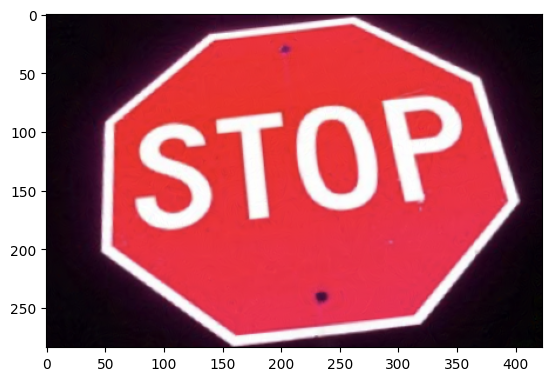

In [37]:
# Show the perturned base image - looks normal to me!

imshow_tensor(ufp_base.detach().cpu())

In [38]:
# Check to see if baseline unfrozen model misclassifies it - yes, it does

poison_inference(ufp_base, uf_model_name)

tensor([[7.4002e-01, 8.5586e-02, 2.7475e-04, 1.7412e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


#Poison The Dataset

In [39]:
# Functions to poison (or unpoison) dataset

def poison_dataset(train_ds, poisoned_base, base, label):
  # place poison back into train_ds under the existing path
  train_ds.replace_by_name(base, label, np.array(poisoned_base.detach().cpu()))

def unpoison_dataset(train_ds, base, label):
  # remove poison from train_ds
  train_ds.remove_by_name(base, label)

In [40]:
# Poison the dataset

poison_dataset(train_ds, ufp_base, base, b_label)

#Unfrozen Poisoned Model and Inference Testing

In [41]:
# Create the dataloader for poisoned train dataset.
poison_ds = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, transforms=True)
poison_dl = DataLoader(poison_ds, batch_size=batch_size, shuffle=True)

train_loss 1.985 test_loss 1.728 test_accuracy 0.582
train_loss 1.618 test_loss 1.556 test_accuracy 0.643
train_loss 1.420 test_loss 1.467 test_accuracy 0.707
train_loss 1.268 test_loss 1.433 test_accuracy 0.695
train_loss 1.154 test_loss 1.402 test_accuracy 0.711
train_loss 1.047 test_loss 1.347 test_accuracy 0.747
train_loss 0.967 test_loss 1.357 test_accuracy 0.751
train_loss 0.898 test_loss 1.321 test_accuracy 0.763
train_loss 0.850 test_loss 1.333 test_accuracy 0.759
train_loss 0.824 test_loss 1.356 test_accuracy 0.747


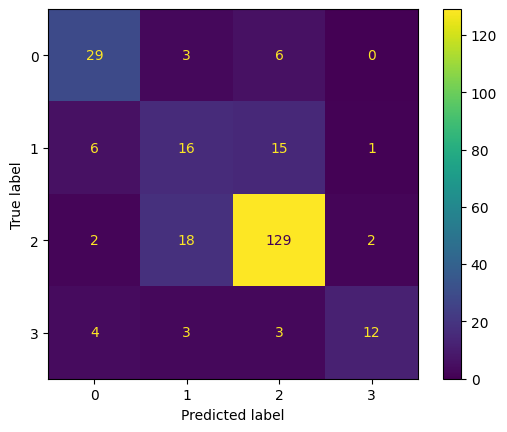

                precision    recall  f1-score   support

trafficlight:0       0.71      0.76      0.73        38
   crosswalk:1       0.40      0.42      0.41        38
  speedlimit:2       0.84      0.85      0.85       151
        stop:3       0.80      0.55      0.65        22

      accuracy                           0.75       249
     macro avg       0.69      0.65      0.66       249
  weighted avg       0.75      0.75      0.75       249

+--------------------------------------------------------------------------------------------+
|                                    Misclassified Images                                    |
+-------------------------------------------------------------+------------+-----------------+
|                             Path                            | True Label | Predicted Label |
+-------------------------------------------------------------+------------+-----------------+
| /content/drive/MyDrive/roadsigns/images_resized/road136.png |     0     

In [42]:
# Train and evaluate unfrozen model on poisoned dataset

ufp_model_name = "unfrozen_poisoned.pt"
ufp_model = RoadSignModel().cuda()
ufp_parameters = filter(lambda p: p.requires_grad, ufp_model.parameters())
ufp_optimizer = torch.optim.Adam(ufp_parameters, lr=uf_lr)

# check classification on unfrozen poisoned model
model_eval(ufp_model, ufp_optimizer, poison_dl, test_dl, test_ds, uf_lr, uf_epochs, ufp_model_name)

0


tensor([[9.5440e-01, 1.0907e-02, 9.2404e-06, 3.4686e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

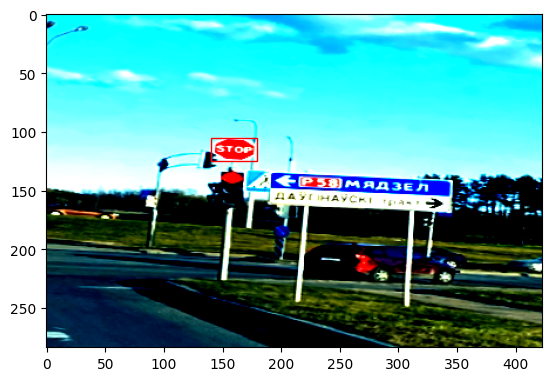

In [43]:
# Check classification of target - didn't work

example_inference(poison_ds, ufp_model_name, target, t_label)

##Add Second Poison to Attack the Same Target

3


tensor([[7.3231e-02, 3.5135e-02, 1.5149e-05, 8.9162e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

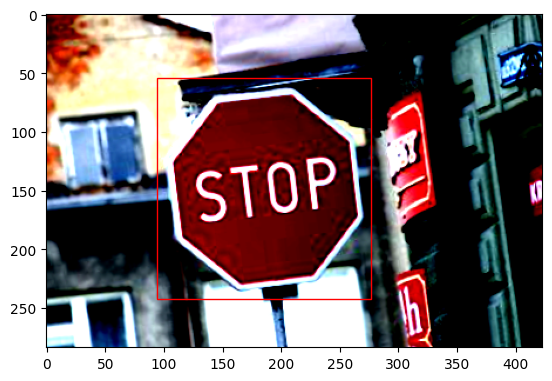

In [44]:
# Find a base image to poison (base is stop sign)

base2 = 'road67.png'
b_label = 3

# check classification on frozen model
example_inference(train_ds, uf_model_name, base2, b_label)

In [45]:
# Poison base instance using target instance using the unfrozen model and show loss during algorithm

model = load_model(uf_model_name)
ufp_base = poison_iters(model, train_ds, test_ds, base2, b_label, target, t_label)

272.68682861328125
33.80235290527344
20.85584831237793
16.6894474029541
13.592557907104492
12.149312019348145
11.476916313171387
10.061643600463867
9.403371810913086
8.89656925201416
8.359386444091797
7.961775302886963
7.550309181213379
7.457790851593018
6.973803520202637
6.6726789474487305
6.521066188812256
6.514596462249756
6.1223063468933105
5.976868629455566


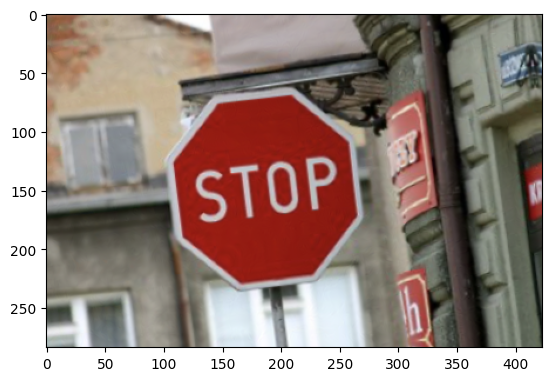

In [46]:
# Show the perturned base image - looks normal to me!

imshow_tensor(ufp_base.detach().cpu())

In [47]:
# Check to see if baseline frozen model misclassifies it - no it does not

poison_inference(ufp_base, uf_model_name)

tensor([[7.7337e-01, 6.6536e-02, 2.4160e-04, 1.5986e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [48]:
# Poison the dataset - with second poison

poison_dataset(train_ds, ufp_base, base2, b_label)

In [49]:
# Create the dataloader for poisoned train dataset - now contains 2 poisons.
poison_ds = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, transforms=True)
poison_dl = DataLoader(poison_ds, batch_size=batch_size, shuffle=True)

train_loss 1.984 test_loss 1.722 test_accuracy 0.594
train_loss 1.620 test_loss 1.552 test_accuracy 0.671
train_loss 1.423 test_loss 1.479 test_accuracy 0.715
train_loss 1.268 test_loss 1.447 test_accuracy 0.699
train_loss 1.154 test_loss 1.404 test_accuracy 0.719
train_loss 1.049 test_loss 1.352 test_accuracy 0.755
train_loss 0.970 test_loss 1.370 test_accuracy 0.743
train_loss 0.900 test_loss 1.335 test_accuracy 0.759
train_loss 0.851 test_loss 1.345 test_accuracy 0.763
train_loss 0.825 test_loss 1.370 test_accuracy 0.731


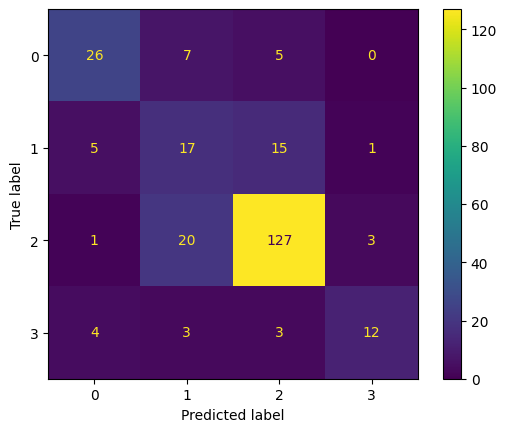

                precision    recall  f1-score   support

trafficlight:0       0.72      0.68      0.70        38
   crosswalk:1       0.36      0.45      0.40        38
  speedlimit:2       0.85      0.84      0.84       151
        stop:3       0.75      0.55      0.63        22

      accuracy                           0.73       249
     macro avg       0.67      0.63      0.64       249
  weighted avg       0.75      0.73      0.74       249

+--------------------------------------------------------------------------------------------+
|                                    Misclassified Images                                    |
+-------------------------------------------------------------+------------+-----------------+
|                             Path                            | True Label | Predicted Label |
+-------------------------------------------------------------+------------+-----------------+
| /content/drive/MyDrive/roadsigns/images_resized/road136.png |     0     

In [50]:
# Train and evaluate unfrozen model on poisoned dataset

ufp2_model_name = "unfrozen_poisoned_2p.pt"
ufp2_model = RoadSignModel().cuda()
ufp2_parameters = filter(lambda p: p.requires_grad, ufp2_model.parameters())
ufp2_optimizer = torch.optim.Adam(ufp2_parameters, lr=uf_lr)

# check classification on frozen model
model_eval(ufp2_model, ufp2_optimizer, poison_dl, test_dl, test_ds, uf_lr, uf_epochs, ufp2_model_name)

0


tensor([[9.3765e-01, 1.4843e-02, 1.7166e-05, 4.7488e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

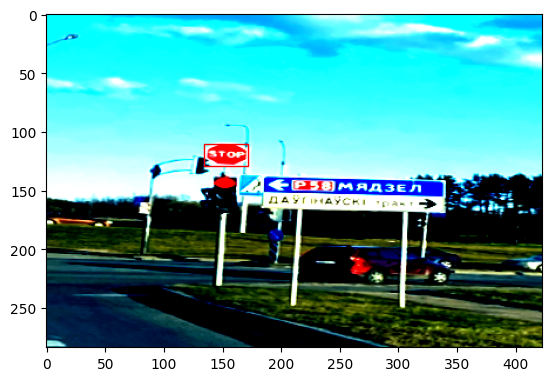

In [51]:
# Check classification of target - didn't work

example_inference(poison_ds, ufp2_model_name, target, t_label)

##Add Third Poison to Attack the Same Target

3


tensor([[3.6713e-02, 3.6871e-02, 3.9517e-04, 9.2602e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

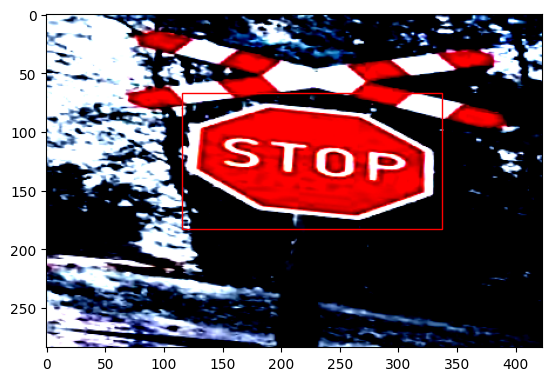

In [52]:
# Find a base image to poison (base is stop sign)

base3 = 'road65.png'
b_label = 3

# check classification on frozen model
example_inference(train_ds, uf_model_name, base3, b_label)

In [53]:
# Poison base instance using target instance using the frozen model and show loss during algorithm

model = load_model(uf_model_name)
ufp_base = poison_iters(model, train_ds, test_ds, base3, b_label, target, t_label)

301.97344970703125
41.94236373901367
27.448833465576172
21.751556396484375
18.628887176513672
16.503765106201172
15.070089340209961
14.086833953857422
13.393482208251953
12.882320404052734
12.43826961517334
12.04484748840332
11.798334121704102
11.406639099121094
11.155251502990723
10.807994842529297
10.611963272094727
10.448369979858398
10.281553268432617
10.103612899780273


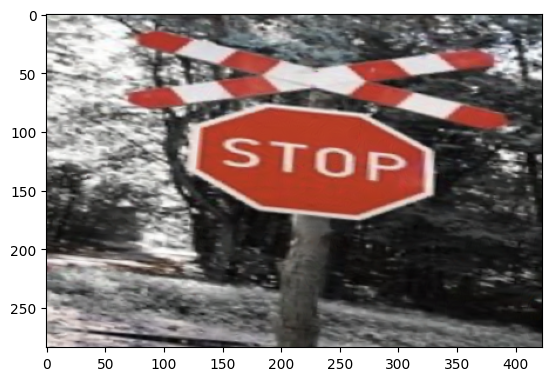

In [54]:
# Show the perturned base image - looks normal to me!

imshow_tensor(ufp_base.detach().cpu())

In [55]:
# Check to see if baseline unfrozen model misclassifies it - no it does not

poison_inference(ufp_base, uf_model_name)

tensor([[7.8245e-01, 6.6169e-02, 2.0471e-04, 1.5118e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [56]:
# Poison the dataset - with third poison

poison_dataset(train_ds, ufp_base, base3, b_label)

In [57]:
# Create the dataloader for poisoned train dataset - now contains 3 poisons.
poison_ds = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, transforms=True)
poison_dl = DataLoader(poison_ds, batch_size=batch_size, shuffle=True)

train_loss 1.985 test_loss 1.716 test_accuracy 0.598
train_loss 1.614 test_loss 1.557 test_accuracy 0.651
train_loss 1.419 test_loss 1.486 test_accuracy 0.691
train_loss 1.264 test_loss 1.459 test_accuracy 0.695
train_loss 1.150 test_loss 1.417 test_accuracy 0.699
train_loss 1.045 test_loss 1.358 test_accuracy 0.723
train_loss 0.968 test_loss 1.383 test_accuracy 0.711
train_loss 0.898 test_loss 1.337 test_accuracy 0.727
train_loss 0.850 test_loss 1.344 test_accuracy 0.723
train_loss 0.825 test_loss 1.367 test_accuracy 0.715


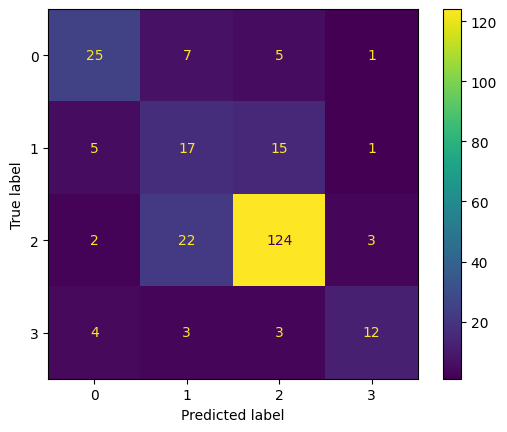

                precision    recall  f1-score   support

trafficlight:0       0.69      0.66      0.68        38
   crosswalk:1       0.35      0.45      0.39        38
  speedlimit:2       0.84      0.82      0.83       151
        stop:3       0.71      0.55      0.62        22

      accuracy                           0.71       249
     macro avg       0.65      0.62      0.63       249
  weighted avg       0.73      0.71      0.72       249

+--------------------------------------------------------------------------------------------+
|                                    Misclassified Images                                    |
+-------------------------------------------------------------+------------+-----------------+
|                             Path                            | True Label | Predicted Label |
+-------------------------------------------------------------+------------+-----------------+
| /content/drive/MyDrive/roadsigns/images_resized/road136.png |     0     

In [58]:
# Train and evaluate frozen model on poisoned dataset

ufp3_model_name = "unfrozen_poisoned_3p.pt"
ufp3_model = RoadSignModel().cuda()
ufp3_parameters = filter(lambda p: p.requires_grad, ufp3_model.parameters())
ufp3_optimizer = torch.optim.Adam(ufp3_parameters, lr=uf_lr)

# check classification on frozen model
model_eval(ufp3_model, ufp3_optimizer, poison_dl, test_dl, test_ds, uf_lr, uf_epochs, ufp3_model_name)

0


tensor([[9.2494e-01, 1.7150e-02, 4.9004e-05, 5.7866e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

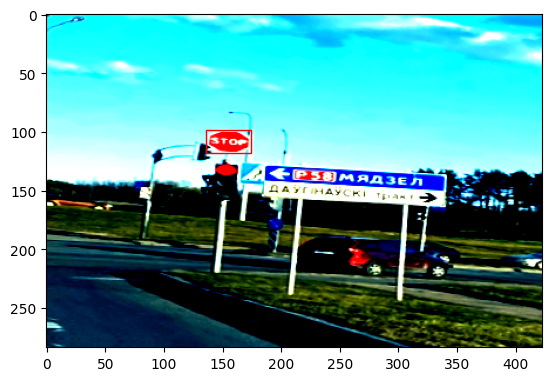

In [59]:
# Check classification of target - didn't work

example_inference(poison_ds, ufp3_model_name, target, t_label)

##What Happens If We Poison With the Same Image With The Stop Sign Label?

0


tensor([[0.2543, 0.0678, 0.0009, 0.6769]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

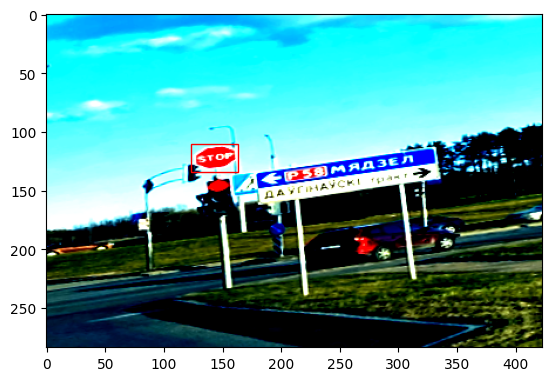

In [60]:
# Find a base image to poison (base is stop sign)

base4 = 'road819.png'
b_label = 3

# check classification on frozen model
example_inference(train_ds, uf_model_name, base4, b_label)

In [61]:
# Poison base instance using target instance using the frozen model and show loss during algorithm

model = load_model(uf_model_name)
ufp_base = poison_iters(model, train_ds, test_ds, base4, b_label, target, t_label)

68.96956634521484
2.214665412902832
1.3217865228652954
1.0154569149017334
0.9208041429519653
0.7197082042694092
0.631424069404602
0.5587167739868164
0.5485298037528992
0.5739263296127319
0.45401808619499207
0.4785119891166687
0.41080349683761597
0.4644467234611511
0.4057018756866455
0.40000587701797485
0.6593527793884277
0.3859301805496216
0.45237845182418823
0.4300505816936493


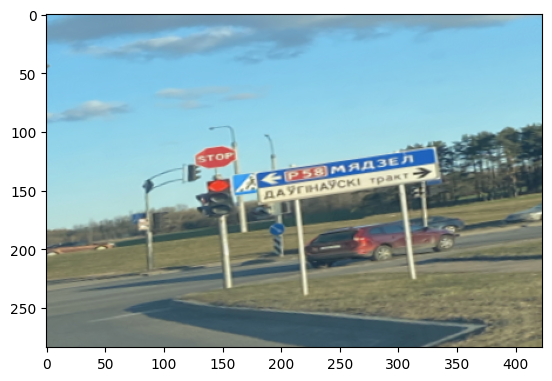

In [62]:
# Show the perturned base image - looks normal to me!

imshow_tensor(ufp_base.detach().cpu())

In [63]:
# Check to see if baseline frozen model misclassifies it - no it does not

poison_inference(ufp_base, uf_model_name)

tensor([[7.7345e-01, 6.8657e-02, 2.0307e-04, 1.5769e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [64]:
# Poison the dataset - with multi-class poison

poison_dataset(train_ds, ufp_base, base4, b_label)

In [65]:
# Create the dataloader for poisoned train dataset - now contains 3 poisons.
poison_ds = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, transforms=True)
poison_dl = DataLoader(poison_ds, batch_size=batch_size, shuffle=True)

train_loss 1.977 test_loss 1.732 test_accuracy 0.590
train_loss 1.609 test_loss 1.565 test_accuracy 0.671
train_loss 1.417 test_loss 1.484 test_accuracy 0.719
train_loss 1.259 test_loss 1.457 test_accuracy 0.715
train_loss 1.145 test_loss 1.419 test_accuracy 0.711
train_loss 1.039 test_loss 1.367 test_accuracy 0.731
train_loss 0.962 test_loss 1.373 test_accuracy 0.735
train_loss 0.894 test_loss 1.337 test_accuracy 0.759
train_loss 0.848 test_loss 1.348 test_accuracy 0.751
train_loss 0.824 test_loss 1.376 test_accuracy 0.739


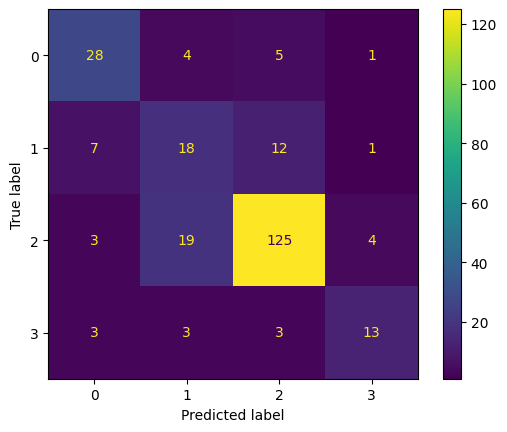

                precision    recall  f1-score   support

trafficlight:0       0.68      0.74      0.71        38
   crosswalk:1       0.41      0.47      0.44        38
  speedlimit:2       0.86      0.83      0.84       151
        stop:3       0.68      0.59      0.63        22

      accuracy                           0.74       249
     macro avg       0.66      0.66      0.66       249
  weighted avg       0.75      0.74      0.74       249

+--------------------------------------------------------------------------------------------+
|                                    Misclassified Images                                    |
+-------------------------------------------------------------+------------+-----------------+
|                             Path                            | True Label | Predicted Label |
+-------------------------------------------------------------+------------+-----------------+
| /content/drive/MyDrive/roadsigns/images_resized/road136.png |     0     

In [66]:
# Train and evaluate frozen model on poisoned dataset

ufp4_model_name = "unfrozen_poisoned_4p.pt"
ufp4_model = RoadSignModel().cuda()
ufp4_parameters = filter(lambda p: p.requires_grad, ufp4_model.parameters())
ufp4_optimizer = torch.optim.Adam(ufp4_parameters, lr=uf_lr)

# check classification on frozen model
model_eval(ufp4_model, ufp4_optimizer, poison_dl, test_dl, test_ds, uf_lr, uf_epochs, ufp4_model_name)

0


tensor([[9.4334e-01, 1.0078e-02, 1.2396e-05, 4.6566e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

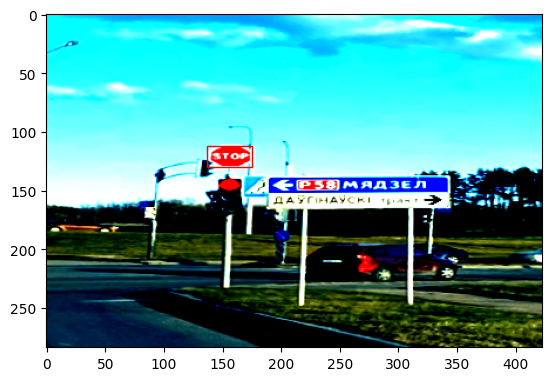

In [67]:
# Check classification of target - didn't work

example_inference(poison_ds, ufp4_model_name, target, t_label)